# I. The Hadamard Test

## Explain how qubits work

0 and 1 ket stuff

measurements  (with probabilites)

superposition (+ and - states)
    why normalization factors 

## Single Qubit Gates

gates rotate particles to different bases

X, Z, Y, S

the dagger operation

## Control Gates

CNOT, phase gate ($R_\theta$)

## Hadmard Gate

If we represent the $|0\rangle$ and $|1\rangle$ states as vectors, we can see that the state $|0\rangle = \begin{pmatrix}1\\0\end{pmatrix}$ showing a $100\%$ chance of measuring $0$ with a $0\%$ chance of measuring 1 and the state $|1\rangle = \begin{pmatrix}0\\1\end{pmatrix}$ showing a $100\%$ probability of measuring $1$ and $0\%$ of measuring $0$. If we do the same with the Hadamard gate we see that $H=\frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix}$ thus effectively transforming any state into superposition.

Let's look at the affect of applying a Hadamard gate to a state $|0\rangle$:

$$|0\rangle  = \begin{pmatrix}1\\0\end{pmatrix} \qquad \qquad H=\frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix}$$

$$\xrightarrow{H} \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix} \begin{pmatrix}1\\0\end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix}1\\1\end{pmatrix} = \begin{pmatrix}\frac{1}{\sqrt{2}}\\\frac{1}{\sqrt{2}}\end{pmatrix}$$

Moving back into dirac notation we can see the affect of applying the Hadamard gate to the $|0\rangle$ state gives:

$$\frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle\right)$$

This shows how the Hadmard gate can turn the $|0\rangle$ state into the "plus state" superposition where the magnitude of the probability of measuring $1$ or $0$ is the same and they are both positive. Looking at the affect of the same gate on the $|1\rangle$ state:

$$|1\rangle  = \begin{pmatrix}0\\1\end{pmatrix} \qquad \qquad H=\frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix}$$
$$\xrightarrow{H\otimes I} \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix} \begin{pmatrix}0\\1\end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix}1\\-1\end{pmatrix} = \begin{pmatrix}\frac{1}{\sqrt{2}}\\-\frac{1}{\sqrt{2}}\end{pmatrix}$$

Again, returning to dirac notation we see that this becomes:

$$\frac{1}{\sqrt{2}}\left(|0\rangle - |1\rangle\right)$$

The gate again transforms the state into superposition but this time brings it to the "minus state" where the magnitude of the probabilities are still the same but they are now a difference instead of a sum. Note that the total probability of each superposition is still $1$:

$$\sqrt{\left(\frac{1}{\sqrt{2}}\right)^{2} + \left(\frac{1}{\sqrt{2}}\right)^{2}} = 1 \qquad \qquad \sqrt{\left(\frac{1}{\sqrt{2}}\right)^{2} + \left(-\frac{1}{\sqrt{2}}\right)^{2}} = 1$$

In [5]:
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram
from qiskit.primitives import BackendSampler
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

## Quantum Phase Estimation (QPE): The Problem Setup

The goal of quantum phase estimation is to estimate the eigenvalues and therefore the phase of a known unitary operator $U$ given a state $|\psi\rangle$, the eigenvector of the eigenvalue $\lambda$ of $U$. 

Suppose that $U$ is an $n\times n$ unitary matrix. All unitary matrices are normal, thus there exists an ortho-normal basis of vectors $\left\{|\psi_1\rangle,\dots,|\psi_N\rangle\right\}$ and complex numbers $\lambda_1 = e^{i\theta_1}, \dots, \lambda_N = e^{i\theta_N}$ where $0\leq \theta_N \leq 2\pi$ such that 

$$U = \sum_{k=1}^{N}\lambda_k|\psi_k\rangle\langle\psi_k|$$

This is called the spectral decomposition of $U$. Since we know each vector $|\psi_k\rangle$ is part of an ortho-normal basis of eigenvectors, we can say that each vector $|\psi_k\rangle$ is an eigenvector of $U$ having eigenvalue $\lambda_k$:

$$U|\psi_k\rangle = \lambda_k|\psi_k\rangle = e^{i\theta_k}|\psi_k\rangle, \quad 0\leq \theta_k \leq 2\pi$$

It is important to note that this is not neccessarily how $U$ works for an arbitrary vector. But because we know there is an ortho-normal basis of eigenvectors, if $U$ is multiplied to any $|\psi_k\rangle$, using the ortho-normality of the vectors we are left with all terms being $0$ except for the final $\lambda_k$ giving us the equation above.

The eigenvalue $\lambda_k$ is also often written as $\lambda_k = e^{i2\pi\varphi_k}$ where $0\leq \varphi_k \leq 1$. We are given a unitary operator $U$, and $|\psi\rangle$ and eigenvector of $U$. We can now set up the phase estimation problem as follows:

$$U|\psi\rangle = e^{i2\pi\varphi}|\psi\rangle, \quad \varphi \in [0,1)$$

We can think of this exponent "$i2\pi\varphi$" as the location of a point around the complex unit circle. The real number $\varphi$ is effectively rotating this point up to $i2\pi \text{ rad}$ as $\varphi$ goes from $0$ to $1$. Ensuring we are including $0$ and not $1$ for the range of $\varphi$ guarantees that we can represent every point on the complex unit circle with a unique value of $\varphi$. This is because $0$ and $2\pi\text{ rad}$ are the same position on the complex unit circle.

In [53]:
angle = 0.5625

In [54]:
def re_circuit(theta):
    circuit = QuantumCircuit(2,1)
    circuit.x(1)
    circuit.barrier()
    circuit.h(0)
    # rotates q0 2*pi*theta radians if q1 is 1
    circuit.cp(theta,0,1)
    circuit.h(0)
    circuit.barrier()
    circuit.measure(0,0)
    return circuit

In [55]:
def im_circuit(theta):
    circuit = QuantumCircuit(2,1)
    circuit.x(1)
    circuit.barrier()
    circuit.h(0)
    circuit.s(0)
    # rotates q0 2*pi*theta radians if q1 is 1
    circuit.cp(theta,0,1)
    circuit.h(0)
    circuit.barrier()
    circuit.measure(0,0)
    return circuit

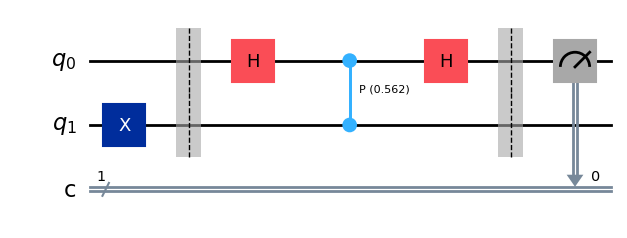

In [56]:
qc = re_circuit(angle)
qc.draw("mpl")

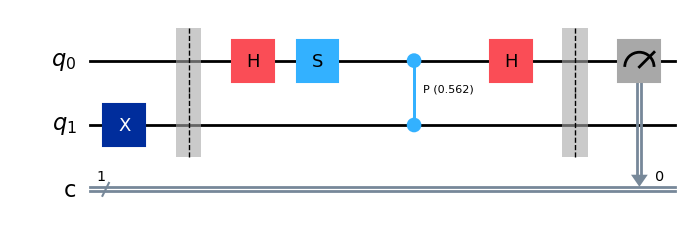

In [57]:
qc2 = im_circuit(angle)
qc2.draw("mpl")

In [58]:
backend = BasicSimulator()

num_of_shots = 10000

re_result = backend.run(qc, shots=num_of_shots).result()   
re_counts = re_result.get_counts()                    

im_result = backend.run(qc2, shots=num_of_shots).result()   
im_counts = im_result.get_counts()                

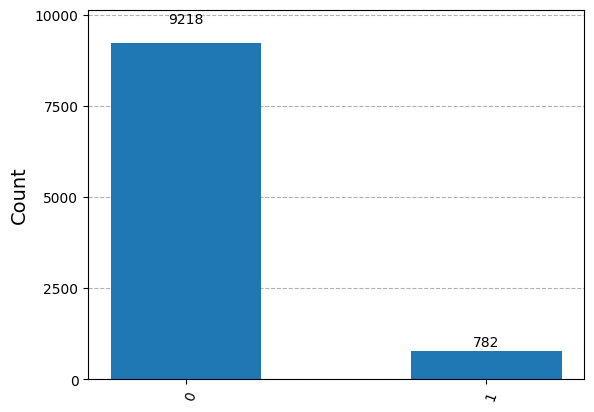

In [59]:
plot_histogram(re_counts)

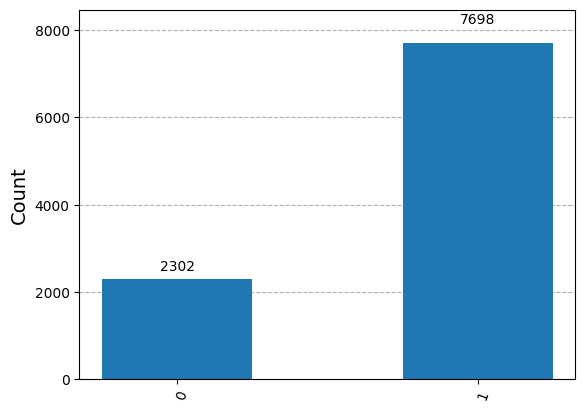

In [60]:
plot_histogram(im_counts)

Say that e^itheta = cos + i sin

show that cos^2 + sin^2 = 1

In [61]:
print('Calculated probability of measuring 1: ', 0.5*(1 - np.cos(angle)))
print('Calculated probability of measuring 0: ',0.5*(1 + np.cos(angle)))
print('Probability of measuring 1', re_counts['1']/num_of_shots)
print('Probability of measuring 0', re_counts['0']/num_of_shots)

Calculated probability of measuring 1:  0.07703775038446603
Calculated probability of measuring 0:  0.922962249615534
Probability of measuring 1 0.0782
Probability of measuring 0 0.9218


3.3 math

(we could just graph sin^2 + cos^2 instead of running a bunch of trials)

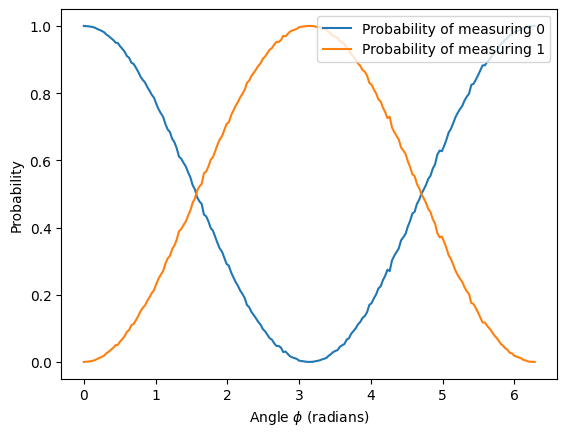

In [62]:
backend = BasicSimulator()

angles = np.linspace(0, 2*pi, 200)
prob0 = []
prob1 = []
expected_phi = angles
for ang in angles:
    circ = re_circuit(ang)
    num_of_shots = int(num_of_shots)
    counts = backend.run(circ, shots=num_of_shots).result().get_counts()
    prob0val = counts.get('0')
    prob1val = counts.get('1')
    if prob0val is not None and prob1val is not None:        
        prob0.append(counts['0']/num_of_shots)
        prob1.append(counts['1']/num_of_shots)
    elif prob0val is None:
        prob0.append(0)
        prob1.append(counts['1']/num_of_shots)
    elif prob1val is None:
        prob1.append(0)
        prob0.append(counts['0']/num_of_shots)
plt.plot(angles, prob0, label = 'Probability of measuring 0')
plt.plot(angles, prob1, label = 'Probability of measuring 1')
plt.xlabel('Angle $\phi$ (radians)')
plt.ylabel('Probability')
plt.legend(loc = 'upper right')
plt.show()

justification of subtracting both the probablities

In [63]:
print("Results of the Trial: ")
print("  Real Circuit:  \t",re_counts)
print("  Imginary Circuit:\t",im_counts)

re_p0 = re_counts['0']/num_of_shots
re_p1 = re_counts['1']/num_of_shots
im_p0 = im_counts['0']/num_of_shots
im_p1 = im_counts['1']/num_of_shots

re = re_p0 - re_p1
#re = 1 - 2*(p1re)
#re = 2*(p0re) - 1

im = im_p1 - im_p0
#im = 2*(p1im) - 1
#im = 1 - 2*(p0im)

ans = np.arctan(im/re)

print("\nWhat we got: ", ans)
print("What we want: ", angle)

Results of the Trial: 
  Real Circuit:  	 {'0': 9218, '1': 782}
  Imginary Circuit:	 {'0': 2302, '1': 7698}

What we got:  0.5690575020241578
What we want:  0.5625


graph explainination

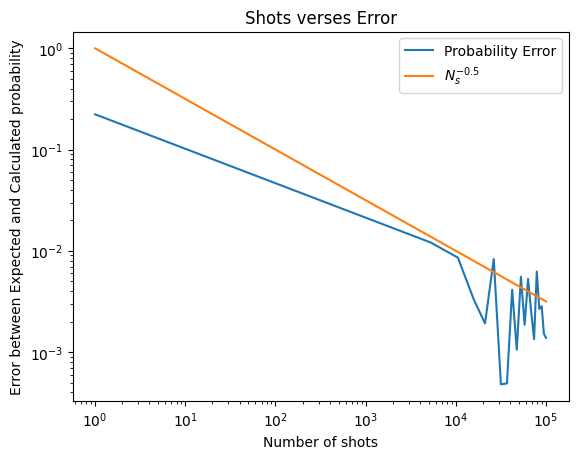

In [64]:
# Construct a graph of error verses number of shots
backend = BasicSimulator()

trials = np.linspace(1, 10**5, 20)
Ns = []
error_diff = []
for num_of_shots in trials:
    # for some reason python doesn't believe this number is an integer
    num_of_shots = int(num_of_shots)
    re_counts = backend.run(qc, shots=num_of_shots).result().get_counts() 
    im_counts = backend.run(qc2, shots=num_of_shots).result().get_counts() 

    re_p0 = re_p1 = im_p0 = im_p1 = 0
    
    if re_counts.get('0') is not None:
        re_p0 = re_counts['0']/num_of_shots
        
    if re_counts.get('1') is not None:
        re_p1 = re_counts['1']/num_of_shots
        
    if im_counts.get('0') is not None:
        im_p0 = im_counts['0']/num_of_shots
        
    if im_counts.get('1') is not None:
        im_p1 = im_counts['1']/num_of_shots

    
    re = re_p0 - re_p1
    im = im_p1 - im_p0
    ans = np.arctan(im/re)
    
    error_diff.append( abs(angle - ans) )
    Ns.append( num_of_shots**(-0.5) )
    
plt.loglog(trials, error_diff, label = 'Probability Error')
plt.loglog(trials, Ns, label = '$N_s^{-0.5}$')
plt.title("Shots verses Error")
plt.xlabel("Number of shots")
plt.ylabel("Error between Expected and Calculated probability")
plt.legend(loc='upper right')
plt.show()